In [1]:
from FDD import FDD
from FDD.SURE import SURE
import numpy as np
import pandas as pd
import torch 
from matplotlib import pyplot as plt
import matplotlib as mpl
import ray
#import boto3
import os
import pickle
from tabulate import tabulate


def ft(x, jumps):
    temp = x**2 + np.sin(10 * x)  # change 10 to any other value to adjust the frequency of oscillation
    for (xj, jj) in jumps:
        if x > xj:
            temp += jj
    return temp

# Redefine the function to generate data with larger jumps, with last one going down
def generate1D(jumps=[(0.2013934, 0.6), (0.4023231, 1), (0.590349, 1.5), (0.7893434, -2)], sigma=0.1, N=500, data=None):
    if data is None:
        data = np.random.rand(N)  # draw N 1D points from a uniform

    # now sample the function values on the data points
    grid_f = np.zeros(data.shape)
    for i in range(data.shape[0]):
        grid_f[i] = ft(data[i], jumps)

    # Normalize function values to [0, 1]
    grid_f = (grid_f - np.min(grid_f)) / np.max(grid_f)  # - np.min(grid_f))

    # now add noise
    grid_sample = grid_f + np.random.normal(loc=0, scale=sigma, size=data.shape)  # add random Gaussian noise
    
    # now cast this data into a standard data format
    X = data.copy()
    Y = grid_sample.copy()
    u = grid_f.copy()

    return (X, Y, u)

def getOriginalImage(model, jumplocs = [0.2013934, 0.4023231, 0.590349, 0.7893434]):
    data = model.grid_x * np.max(model.X_raw, axis = 0) + np.min(model.X_raw, axis = 0) # draw 1000 2D points from a uniform
    data = data.squeeze()
    # original boundary
    
    temp_bdy = np.zeros_like(data)
    for jump in jumplocs:
        temp_bdy += ((data+0.5*model.resolution) < jump) * ((np.append(data[1:], 0) + 1.5*model.resolution) > jump)

    x, y, u = generate1D(N = data.size, data=data)


    return u, temp_bdy



In [2]:
#----------------
# parameters
#----------------
sigma=0.05
S = 50
N = 3000
lmbda = 100
nu = 0.002
main_dir = "/home/dvdijcke/"
data_out = os.path.join(main_dir, "data", "out")
figs_dir = os.path.join(main_dir, "results", "figs")
tabs_dir = os.path.join(main_dir, "results", "tabs")

df = pd.read_csv(os.path.join(data_out, "simulations", "2022-08-02", "simulations_1d_sigma_0.05.csv"))


In [3]:
df.head()

,X_0,Y_jumpfrom,Y_jumpto,Y_jumpsize,N,S,s,sigma,lambda,nu,jump_neg,jump_pos,mse
0,0.038094,0.079442,0.123155,0.043713,500,32.0,0,0.05,98.671191,0.000138,0.0,0.235294,0.115176
1,0.078600,0.123155,0.200395,0.077240,500,32.0,0,0.05,98.671191,0.000138,0.0,0.235294,0.115176
2,0.122759,0.200395,0.241324,0.040929,500,32.0,0,0.05,98.671191,0.000138,0.0,0.235294,0.115176
3,0.198198,0.248264,0.274683,0.026419,500,32.0,0,0.05,98.671191,0.000138,0.0,0.235294,0.115176
4,0.400189,0.264948,0.195254,-0.069694,500,32.0,0,0.05,98.671191,0.000138,0.0,0.235294,0.115176


In [4]:
N = df['N'].max()
lmbda, nu, sigma, S = df[['lambda', 'nu', 'sigma', 'S']].loc[0]



## Create plots

In [23]:
np.random.seed(3340)
# Generate data with reduced noise
X, Y, U = generate1D(sigma=0.05, N=N)

resolution = 1/int(0.05*Y.size)
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False)

results = model.run()
u = results['u']
J_grid = results['J']
jumps = results['jumps']

/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [24]:
u_lower = results['u_lower']
u_upper = results['u_upper']
J_lower = results['J_lower']

In [25]:
J_lower.sum()

3

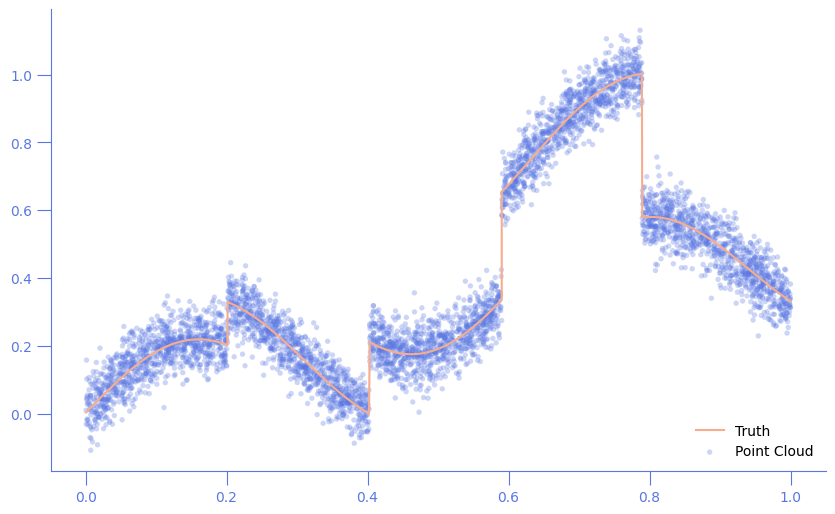

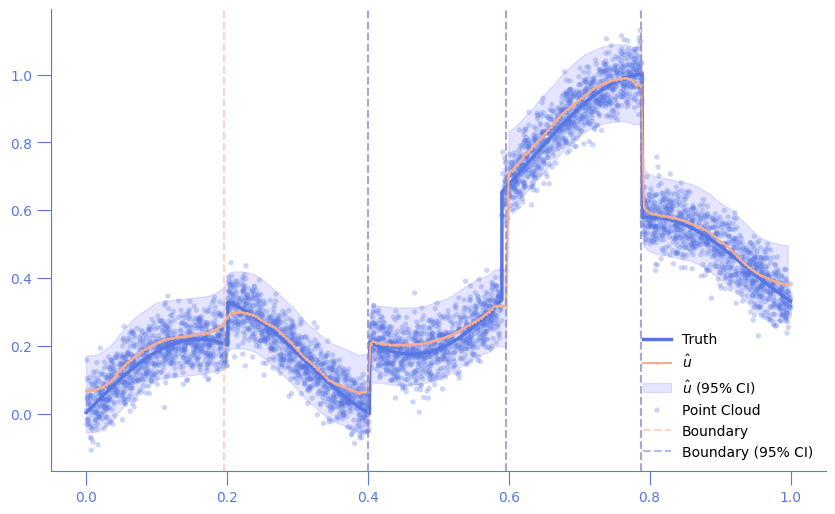

In [30]:
# plot figures
cmap = mpl.colormaps.get_cmap('coolwarm')
c1 = cmap(0.1)
c2 = cmap(0.7)

def prettify(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(c1)
    ax.spines['bottom'].set_color(c1)
    ax.tick_params(axis='both', which='both', colors=c1, size=10)
    ax.yaxis.label.set_color(c1)
    ax.xaxis.label.set_color(c1)
    leg = plt.legend(loc="lower right")
    leg.get_frame().set_alpha(0)

# cb = "#d7e3ff"
# cr = "#f7ccc1"

# Sort data for plotting
sort_inds = np.argsort(X)
X_sorted = X[sort_inds]
Y_sorted = Y[sort_inds]
U_sorted = U[sort_inds]

# Plot truth
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X_sorted, U_sorted, label='Truth', color=c2)
ax.scatter(X_sorted, Y_sorted, s=15, label='Point Cloud', color=c1,alpha=0.3, edgecolors='none')
prettify(ax)
plt.savefig(os.path.join(figs_dir, "simulation_1d_truth.pdf"), bbox_inches='tight')

# plot estimates 
fig, ax = plt.subplots(figsize=(10,6))
#plt.scatter(model.grid_x, u, s=1)
ax.plot(X_sorted, U_sorted, label='Truth', color=c1, linewidth=2.5)
ax.plot(model.grid_x, u, '-o', markersize=1, c=c2, label = r"$\hat{u}$")
ax.fill_between(model.grid_x.squeeze(), u_lower, u_upper, color='b', alpha=.1, label = r"$\hat{u}$ (95% CI)")
ax.scatter(X_sorted, Y_sorted, s=15, label='Point Cloud', color=c1,alpha=0.3, edgecolors='none')

# plot mean jump locations
jumplocs = (np.where(J_grid==1)[0] / J_grid.size).tolist()
for xc in jumplocs:
    if xc == jumplocs[0]:
        plt.axvline(x=xc, color=c2, linestyle='--', alpha=0.5, label="Boundary")
    else:
        plt.axvline(x=xc, color=c2, linestyle='--', alpha=0.5)
        
        
# plot lower bound jump locations
jumplocs = (np.where(J_lower==1)[0] / J_lower.size).tolist()
for xc in jumplocs:
    if xc == jumplocs[0]:
        plt.axvline(x=xc, color=c1, alpha=0.5, linestyle='--', label="Boundary (95% CI)")
    else:
        plt.axvline(x=xc, color=c1, alpha=0.5, linestyle='--')

    
prettify(ax)
plt.savefig(os.path.join(figs_dir, "simulation_1d_estimate.pdf"), bbox_inches='tight')


In [8]:
uu, J_true = getOriginalImage(model)

pos = ((J_true ) * (J_grid+np.append(J_grid[1:],0 )))

In [72]:
(J_true * (1-pos) * J_grid).sum()

0.0

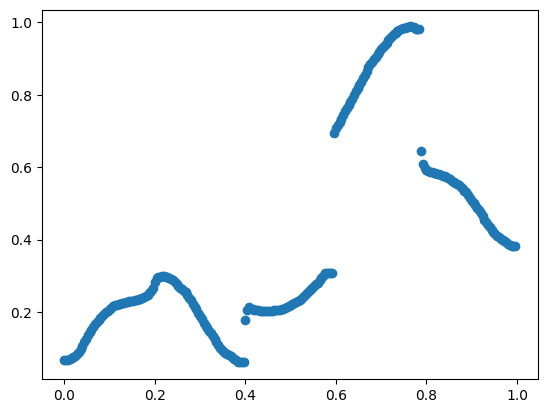

In [10]:
plt.scatter(model.grid_x, u)

In [5]:
import inspect
lines = inspect.getsource(FDD.adjustBoundary)
print(lines)

    def adjustBoundary(self, u, J_grid):
        for k in range(1, len(J_grid) - 1):
            if J_grid[k] == 1:
                if (J_grid[k-1] == 0) and (J_grid[k+1]==1):
                    u[k+1] = u[k].copy()
                    J_grid[k] = 0
        return (u, J_grid)



In [44]:
u[97]

0.06029170772548198

In [8]:
temp = pd.DataFrame(jumps)

In [9]:
temp


,X_0,Y_jumpfrom,Y_jumpto,Y_jumpsize
0,0.200168,0.266644,0.282389,0.015746
1,0.404403,0.063677,0.206423,0.142746
2,0.599895,0.317986,0.706896,0.388910
3,0.791926,0.969803,0.608419,-0.361384


In [13]:
jumpsizes

array([ 0.12896662,  0.21367482,  0.31956007, -0.42163669])

In [76]:
        k = np.array(np.where(J_grid == 1))
        

        # Store the average points
        Y_jumpfrom = []
        Y_jumpto = []
        Y_jumpsize = []
        Y_boundary = []
        X_jumpfrom = []
        X_jumpto = []


In [77]:
i = 0

origin_points = []
dest_points = []

# Get the coordinates of the current boundary point
point = k[:, i]

# Initialize a list to store the neighboring hypervoxels
#neighbors = list(self.explore(point, J_grid))
neighbors = []  
count = 0
for d in range(J_grid.ndim):
    neighbor = point.copy()
    if neighbor[d] < J_grid.shape[d] - 1:
        neighbor[d] += 1
        neighbors.append(neighbor)
        count += 1
if count == 0:
    neighbors.append(point.copy())
                    

In [78]:
neighbors

[array([50])]

In [81]:
# origin_points
origin_points = model.grid_x_og[tuple(point)]
if len(origin_points) == 0:
    origin_points = self.grid_x[tuple(point)] + model.resolution / 2
Yjumpfrom = float(u[tuple(point)])


# jumpfrom point
origin_points = np.stack(origin_points).squeeze()
if (origin_points.ndim > 1) | ((origin_points.ndim == 1) and (origin_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
    jumpfrom = np.mean(origin_points, axis = 0)
else:
    jumpfrom = origin_points

In [85]:
# jumpto point
pointslist = [model.grid_x_og[tuple(neighbors[j])] if model.grid_x_og[tuple(neighbors[j])] != []  # if grid cell is empty, assign centerpoint
                else [model.grid_x[tuple(neighbors[j])] + model.resolution / 2] for j in range(len(neighbors))]

# get point with largest jump size
Yjumptos = [u[tuple(neighbors[j])] for j in range(len(neighbors))]
Yjumpsizes = [abs(Yjumptos[j] - Yjumpfrom) for j in range(len(neighbors))]
idx = np.argmax(Yjumpsizes)
Yjumpto = Yjumptos[idx]
dest_points = model.grid_x_og[tuple(neighbors[idx])]
if len(dest_points) == 0:
    dest_points = model.grid_x[tuple(neighbors[idx])] + model.resolution / 2
dest_points = np.stack(dest_points).squeeze()

if (dest_points.ndim > 1) or ((dest_points.ndim == 1) and (dest_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
    jumpto = np.mean(dest_points, axis = 0)
else:
    jumpto = dest_points

In [95]:
u.shape

(250,)

In [ ]:
        k = np.array(np.where(J_grid == 1))
        

        # Store the average points
        Y_jumpfrom = []
        Y_jumpto = []
        Y_jumpsize = []
        Y_boundary = []
        X_jumpfrom = []
        X_jumpto = []


        # Iterate over the boundary points
        for i in range(k.shape[1]):

            origin_points = []
            dest_points = []

            # Get the coordinates of the current boundary point
            point = k[:, i]

            # Initialize a list to store the neighboring hypervoxels
            #neighbors = list(self.explore(point, J_grid))
            neighbors = []  
            count = 0
            for d in range(J_grid.ndim):
                neighbor = point.copy()
                if neighbor[d] < J_grid.shape[d] - 1:
                    neighbor[d] += 1
                    neighbors.append(neighbor)
                    count += 1
            if count == 0:
                neighbors.append(point.copy())
                    

            # Check if there are any valid neighbors
            if neighbors:

                # origin_points
                origin_points = self.grid_x_og[tuple(point)]
                if len(origin_points) == 0:
                    origin_points = self.grid_x[tuple(point)] + self.resolution / 2
                Yjumpfrom = float(u[tuple(point)])


                # jumpfrom point
                origin_points = np.stack(origin_points).squeeze()
                if (origin_points.ndim > 1) | ((origin_points.ndim == 1) and (origin_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
                    jumpfrom = np.mean(origin_points, axis = 0)
                else:
                    jumpfrom = origin_points


                # jumpto point
                pointslist = [self.grid_x_og[tuple(neighbors[j])] if self.grid_x_og[tuple(neighbors[j])] != []  # if grid cell is empty, assign centerpoint
                                else [self.grid_x[tuple(neighbors[j])] + self.resolution / 2] for j in range(len(neighbors))]

                if average:
                    counts = [len(pointslist[j]) for j in range(len(neighbors))]
                    total = sum(counts) # TODO: jump sizes on diagonal boundary sections are off
                    Yjumpto = np.sum([(u[tuple(neighbors[j])] * counts[j]) / total for j in range(len(neighbors))]) # proper unweighted average of the y values
                    dest_points = np.stack([item for sublist in pointslist for item in sublist]).squeeze()
                    if dest_points.ndim > 1: # if there are multiple points in the hypervoxel, take the mean
                        jumpto = np.mean(dest_points, axis = 0)
                    else:
                        jumpto = dest_points
                else:
                    # get point with largest jump size
                    Yjumptos = [u[tuple(neighbors[j])] for j in range(len(neighbors))]
                    Yjumpsizes = [abs(Yjumptos[j] - Yjumpfrom) for j in range(len(neighbors))]
                    idx = np.argmax(Yjumpsizes)
                    Yjumpto = Yjumptos[idx]
                    dest_points = self.grid_x_og[tuple(neighbors[idx])]
                    if len(dest_points) == 0:
                        dest_points = self.grid_x[tuple(neighbors[idx])] + self.resolution / 2
                    dest_points = np.stack(dest_points).squeeze()
                    
                    if (dest_points.ndim > 1) or ((dest_points.ndim == 1) and (dest_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
                        jumpto = np.mean(dest_points, axis = 0)
                    else:
                        jumpto = dest_points
                    
                    # dists = [[np.linalg.norm(jumpfrom - point) for point in pointslist[j]] for j in range(len(neighbors))]
                    # idx = np.argmin([np.argmin(sublist) for sublist in dists])
                    # closest = tuple(neighbors[idx])
                    # Yjumpto = u[closest]

                    # dest_points = self.grid_x_og[closest]
                    # if len(dest_points) == 0:
                    #     dest_points = self.grid_x[closest] + self.resolution / 2
                    # dest_points = np.stack(dest_points).squeeze()

                    # if dest_points.ndim > 1: # if there are multiple points in the hypervoxel, take the mean
                    #     jumpto = np.mean(dest_points, axis = 0)
                    # else:
                    #     jumpto = dest_points
                        

                # append to lists
                Y_boundary.append((jumpfrom + jumpto) / 2)
                Y_jumpfrom.append(Yjumpfrom)
                Y_jumpto.append(Yjumpto)
                Y_jumpsize.append(Yjumpto - Yjumpfrom)
                X_jumpfrom.append(jumpfrom)
                X_jumpto.append(jumpto)

        if Y_boundary:
            Y_boundary = np.stack(Y_boundary)
            Y_jumpfrom = np.stack(Y_jumpfrom)
            Y_jumpto = np.stack(Y_jumpto)
            Y_jumpsize = np.stack(Y_jumpsize)
            
            if Y_boundary.ndim == 1:
                Y_boundary = np.expand_dims(Y_boundary, -1)
        

            # create named array to return
            rays = [Y_boundary[:,d] for d in range(Y_boundary.shape[1])] + [Y_jumpfrom, Y_jumpto, Y_jumpsize]
            names = ["X_" + str(d) for d in range(Y_boundary.shape[1])] + ["Y_jumpfrom", "Y_jumpto", "Y_jumpsize"]
            jumps = pd.DataFrame(np.core.records.fromarrays(rays, names=names))
        else:
            jumps = None

        return jumps

## Create table

In [91]:
def format_value(value):
    if isinstance(value, int):
        return str(value)
    return "{:.4f}".format(value)


def create_latex_subtables(df, sigma=0.05):
    df_sigma = df.copy()

    # Get the unique alpha values, sorted
    # alphas = sorted(df_sigma['alpha'].unique())

    # Initialize the final LaTeX table string
    latex_tables = "\\begin{subtable}{\\textwidth}\n\\centering\n"



    # Get the subset of the dataframe with the current alpha value
    df_alpha = df_sigma.sort_values('N')

    # Remove the 'alpha', 'S', 'lambda', 'nu', 'sigma', 'Y_jumpfrom', and 'Y_jumpto' columns
    df_alpha = df_alpha.drop(['S', 'lambda', 'nu', 'sigma', 'Y_jumpfrom', 'Y_jumpto'], axis=1)

    # reorder columns
    cols = ['N', 'mse', 'mse_est', 'bias', 'jump_neg', 'jump_pos']
    df_alpha = df_alpha[cols]

    df_alpha.rename(columns={'mse' : 'MSE',
                            'jump_neg' : 'FNR',
                            'jump_pos' : 'FPR'}, 
                    inplace=True)

    df_alpha['N'] = df_alpha['N'].astype(int)
    # format value on df_alpha
    df_alpha = df_alpha.applymap(format_value)


    # Generate the LaTeX table
    latex_table = tabulate(df_alpha, tablefmt="latex_booktabs", headers="keys", showindex=False)

    # Get the lambda and nu values
    lambda_val = df_sigma['lambda'].values[0]
    nu_val = df_sigma['nu'].values[0]

    # Add the sub-table to the final LaTeX tables string
    nrow = df_alpha.shape[1]
    latex_tables += "%s \\\\ SURE: $\\lambda$ = %.4f, $\\nu$ = %.4f  \\\\ \n\n" % (latex_table, lambda_val, nu_val)


    # replace the names that require maths (tabulate processes them as text)
    # latex_tables = latex_tables.replace(f"alpha", f"$ \\alpha $")
    # latex_tables = latex_tables.replace("Y\\_jumpsize", "$ \\hat{\\alpha} $")
    latex_tables = latex_tables.replace("mse\\_est", "MSE $\\tau_{\\mathrm{FD}}$")
    latex_tables = latex_tables.replace("bias", "Bias $\\tau_{\\mathrm{FD}}$")



    latex_tables += "\\end{subtable}"
    
    
    return latex_tables

In [17]:
jumplist = np.array([(0.2013934, 0.6), (0.4023231, 1), (0.590349, 1.5), (0.7893434, -2)])


X,Y,U = generate1D(jumps=[],sigma=0.05, N=N)
data = np.random.rand(N)  # draw N 1D points from a uniform

# now sample the function values on the data points
grid_f = np.zeros(data.shape)
for i in range(data.shape[0]):
    grid_f[i] = ft(data[i], jumplist)

jumpsizes = ((jumplist[:,1] - grid_f.min()) / grid_f.max())
jumplocs = jumplist[:,0]

In [18]:
jumpdf = pd.DataFrame(np.stack([jumplocs , jumpsizes]).T, columns = ["X_0", "alpha"])

In [19]:
jumpdf.sort_values("X_0", inplace=True)
df.sort_values("X_0", inplace=True)

dfout = pd.merge_asof(df, jumpdf, on="X_0", direction="nearest")

In [48]:
# Group by 'alpha', 'N', and 'S' and calculate the mean 'Y_jumpsize'
dfout['Y_jumpsize'] = dfout['Y_jumpsize'].abs()
dfout['bias'] = (dfout['Y_jumpsize'] - dfout['alpha'].abs())
dfout['mse_est'] = dfout['bias']**2 
mean_jumpsize = dfout.groupby(['alpha', 'N', 'S', 's']).agg({'Y_jumpsize' : 'mean', 
                                            'mse' : 'mean', 
                                            'mse_est' : 'mean',
                                            'bias' : 'mean',
                                            'jump_neg' : 'mean',
                                            'jump_pos' : 'mean',
                                            'Y_jumpfrom' : 'mean',
                                            'Y_jumpto' : 'mean',
                                            'lambda' : 'mean', 
                                            'nu' : 'mean', 
                                            'sigma' : 'mean'}).reset_index()
mean_jumpsize = mean_jumpsize.groupby(['N', 'S']).agg({'Y_jumpsize' : 'mean', 
                                            'mse' : 'mean', 
                                            'mse_est' : 'mean',
                                            'bias' : 'mean',
                                            'jump_neg' : 'mean',
                                            'jump_pos' : 'mean', 
                                            'Y_jumpfrom' : 'mean',
                                            'Y_jumpto' : 'mean',
                                            'lambda' : 'mean',
                                            'alpha' : 'mean',
                                            'nu' : 'mean', 
                                            'sigma' : 'mean'}).reset_index()

In [92]:
latex_table = create_latex_subtables(mean_jumpsize)
with open(os.path.join(tabs_dir, 'simulations_1D_sigma_0.05.tex'), 'w') as f:
    f.write(latex_table)


In [80]:
mean_jumpsize

,N,S,Y_jumpsize,mse,mse_est,bias,jump_neg,jump_pos,Y_jumpfrom,Y_jumpto,lambda,alpha,nu,sigma
0,500,32.0,0.173627,0.078857,0.035818,-0.083918,-0.04367,0.193250,0.262260,0.319744,98.671191,-0.012811,0.000138,0.05
1,1000,32.0,0.192108,0.046106,0.030443,-0.065885,0.00000,0.109855,0.324635,0.344922,98.671191,-0.008941,0.000138,0.05
2,5000,32.0,0.241582,0.001191,0.009931,-0.052920,0.00000,0.018035,0.442975,0.480098,98.671191,0.048581,0.000138,0.05


In [93]:
latex_table
    

'\\begin{subtable}{\\textwidth}\n\\centering\n\\begin{tabular}{rrrrrr}\n\\toprule\n    N &    MSE &   MSE $\\tau_{\\mathrm{FD}}$ &    Bias $\\tau_{\\mathrm{FD}}$ &     FNR &    FPR \\\\\n\\midrule\n  500 & 0.0789 &    0.0358 & -0.0839 & -0.0437 & 0.1933 \\\\\n 1000 & 0.0461 &    0.0304 & -0.0659 &  0      & 0.1099 \\\\\n 5000 & 0.0012 &    0.0099 & -0.0529 &  0      & 0.018  \\\\\n\\bottomrule\n\\end{tabular} \\\\ SURE: $\\lambda$ = 98.6712, $\\nu$ = 0.0001  \\\\ \n\n\\end{subtable}'

In [90]:
df

,N,S,Y_jumpsize,mse,mse_est,bias,jump_neg,jump_pos,Y_jumpfrom,Y_jumpto,lambda,alpha,nu,sigma
0,500,32.0,0.173627,0.078857,0.035818,-0.083918,-0.04367,0.193250,0.262260,0.319744,98.671191,-0.012811,0.000138,0.05
1,1000,32.0,0.192108,0.046106,0.030443,-0.065885,0.00000,0.109855,0.324635,0.344922,98.671191,-0.008941,0.000138,0.05
2,5000,32.0,0.241582,0.001191,0.009931,-0.052920,0.00000,0.018035,0.442975,0.480098,98.671191,0.048581,0.000138,0.05


## Misc



cmap = mpl.colormaps.get_cmap('coolwarm')
c1 = cmap(0.1)
c2 = cmap(0.7)

# Sort data for plotting
sort_inds = np.argsort(X)
X_sorted = X[sort_inds]
Y_sorted = Y[sort_inds]
U_sorted = U[sort_inds]

fig, ax = plt.subplots(figsize=(10,6))
#  * np.max(model.Y_raw) + np.min(model.Y_raw)
plt.scatter(model.grid_x, u, s=25)
#plt.plot(model.grid_x, u, '-o', markersize=1, c=c1)
#ax.scatter(model.grid_x, model.grid_y * np.max(model.Y_raw) + np.min(model.Y_raw), s=25, label='Point Cloud', color=c1, edgecolors='none')
#ax.scatter(X_sorted, Y_sorted, s=25, label='Point Cloud', color="red",alpha=0.3, edgecolors='none')


In [15]:
temp = pd.DataFrame(jumps)
temp

,X_0,Y_jumpfrom,Y_jumpto,Y_jumpsize
0,0.200168,0.266644,0.282389,0.015746
1,0.395897,0.063677,0.078879,0.015202
2,0.400361,0.078879,0.178405,0.099526
3,0.404403,0.178405,0.206423,0.028019
4,0.583836,0.317986,0.345697,0.027711
5,0.588027,0.345697,0.567565,0.221868
6,0.592397,0.567565,0.672088,0.104523
7,0.596168,0.672088,0.693189,0.021101
8,0.599895,0.693189,0.706896,0.013707
9,0.783904,0.969803,0.871820,-0.097983


In [16]:
J_grid.sum()

12

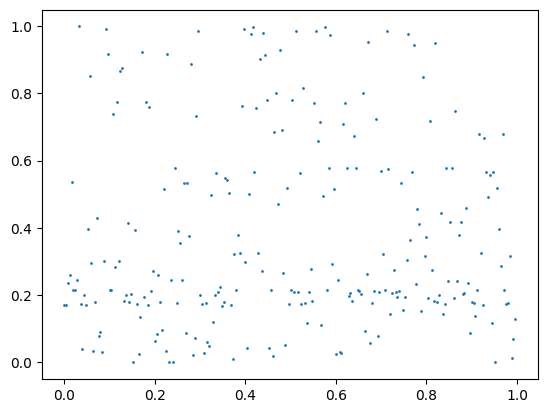

In [96]:
plt.scatter(model.grid_x, u, s=1)


In [10]:
 np.min(model.Y_raw)

-0.06612661481378704

In [25]:
from types import MethodType

def adjustBoundary(self, u, J_grid):

    return (u, J_grid)
model.adjustBoundary = MethodType(adjustBoundary, model)

In [1]:
from FDD import FDD
from FDD.SURE import SURE
import numpy as np
import pandas as pd
import torch 
from matplotlib import pyplot as plt
import ray
#import boto3
import os
import pickle

def ft(x, jumps):
    temp = x**2 + np.sin(10 * x)  # change 10 to any other value to adjust the frequency of oscillation
    for (xj, jj) in jumps:
        if x > xj:
            temp += jj
    return temp

# Redefine the function to generate data with larger jumps, with last one going down
def generate1D(jumps=[(0.2013934, 0.6), (0.4023231, 1), (0.590349, 1.5), (0.7893434, -2)], sigma=0.1, N=500):
    data = np.random.rand(N)  # draw N 1D points from a uniform

    # now sample the function values on the data points
    grid_f = np.zeros(data.shape)
    for i in range(data.shape[0]):
        grid_f[i] = ft(data[i], jumps)

    # Normalize function values to [0, 1]
    grid_f = (grid_f - np.min(grid_f)) / np.max(grid_f)  # - np.min(grid_f))
    

    # now add noise
    grid_sample = grid_f + np.random.normal(loc=0, scale=sigma, size=data.shape)  # add random Gaussian noise
    
    # now cast this data into a standard data format
    X = data.copy()
    Y = grid_sample.copy()
    u = grid_f.copy()
    
    return (X, Y, u)

def getOriginalImage(model, jumplocs = [0.2013934, 0.4023231, 0.590349, 0.7893434]):
    data = model.grid_x * np.max(model.X_raw, axis = 0) + np.min(model.X_raw, axis = 0) # draw 1000 2D points from a uniform
    data = data.squeeze()
    # original boundary
    
    temp_bdy = np.zeros_like(data)
    for jump in jumplocs:
        temp_bdy += ((data+model.resolution) < jump) * ((np.append(data[1:], 0) + model.resolution) > jump)

    x, y, u = generate1D(N = data.size)


    return u, temp_bdy





#----------------
# parameters
#----------------
N_list = [500]
N_sure = max(N_list)
S = 32
num_samples = 1 #  400 # 400 # 200
num_sims = 1 # 100 # 100 # 100
R = 1 #  3 # 3 # 5
num_gpus = 1
num_cpus = 2
fdate = "2022-07-31"

@ray.remote(num_gpus=num_gpus, num_cpus=num_cpus)  # This decorator indicates that this function will be distributed, with each task using one GPU.
def train(config, sigma, N, lmbda, nu, S):
    # Here we randomly generate training data.
    print("running one simulation")
    X, Y, U = generate1D(sigma=sigma, N=N)

    #tune.utils.wait_for_gpu(target_util = 0.1, retry = 100000)


    if torch.cuda.is_available(): # cuda gpus
        device_id = torch.cuda.current_device() 
        device = torch.device("cuda:{}".format(device_id)) 
        torch.cuda.set_device(device)

    elif torch.backends.mps.is_available(): # mac gpus
        device = torch.device("mps")

    resolution = 1/int(N*0.05)
    model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 100000, tol = 5e-5, resolution=resolution,
            pick_nu = "MS", scaled = True, scripted = False)

    u, jumps, J_grid, nrj, eps, it = model.run()
    
    print("done running")

    u_original, J_original = getOriginalImage(model)


    mse = np.mean((u - u_original)**2)
    jump_pos = np.sum(J_grid * (1-J_original)) / np.sum(1-J_original) # false positive rate (significance)
    jump_neg = np.sum((1-J_grid) * (J_original)) / np.sum(J_original) # false negative rate (1-power)

    temp = pd.DataFrame(jumps)
    temp[['N', 'S', 's', 'sigma', 'lambda', 'nu', 'jump_neg', 
          'jump_pos', 'mse']] = N, S, config, sigma, lmbda, nu, jump_neg, jump_pos, mse
    return temp

np.random.seed(50345)

In [2]:


dflist = []

for sigma in [0.05]: #, 0.05]:

    print("Running SURE")
    # run SURE once for largest N
    X, Y, U = generate1D(sigma=sigma, N=N_sure)
    resolution = 1/int(np.sqrt(0.05*N_sure))
    model = FDD(Y, X, level = S, lmbda = 20, nu = 0.01, iter = 10000, tol = 5e-5, pick_nu = "MS", 
                scaled = True, resolution=resolution, scripted=False)
#     res = SURE(tuner=True, num_samples=num_samples, model=model, R=R, 
#             num_gpus=num_gpus, num_cpus=num_cpus)
#     best = res.get_best_result(metric = "score", mode = "min")

#     config = best.metrics['config']
#     lmbda, nu = config['lmbda'], config['nu']


    lmbda = 120
    nu = 0.0016
    # model.lmbda = lmbda
    # model.nu = nu
    # model.tol = 5e-6
    # u, jumps, J_grid, nrj, eps, it = model.run()
    # temp = pd.DataFrame(jumps)
    # temp['Y_jumpsize'].abs().mean()

    # plt.hist(temp['Y_jumpsize'])
    # plt.show()

    # test = temp[temp['Y_jumpsize'].abs() < 0.02]
    # plt.scatter(test['X_0'], test['X_1'], color = "blue")
    # test = temp[temp['Y_jumpsize'].abs() > 0.02]
    # plt.scatter(test['X_0'], test['X_1'], color = "red")

    print("Running simulations")
    sims = list(range(num_sims))  # 100 simulations
#     results = ray.get([train.remote(config, sigma, N, lmbda, nu, S) for config in sims for N in N_list])

#     temp = pd.concat(results)
#     dflist.append(temp)
#     temp.to_csv("/home/dvdijcke/data/out/simulations/" + fdate + "/simulations_1d_sigma_" + str(sigma) + ".csv", index=False)

#     print(f"Done with sigma {sigma}")

Running SURE
Running simulations


In [2]:
[train.remote(config, sigma, N, lmbda, nu, S) for config in sims for N in N_list]

[ObjectRef(82891771158d68c1ffffffffffffffffffffffff0100000001000000)]

In [3]:
results = ray.get([train.remote(config, sigma, N, lmbda, nu, S) for config in sims for N in N_list])


2023-07-31 12:21:07,897	INFO worker.py:1625 -- Started a local Ray instance.


(train pid=2003765) running one simulation


(train pid=2003765) /home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train pid=2003765)   tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
(train pid=2003765) /home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train pid=2003765)   sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


(train pid=2003765) done running


In [5]:
torch.cuda.empty_cache()

In [6]:
del(model)

In [4]:
config = 1
N=500
sigma=0.05
nu = 0.001
lmbda=100
X, Y, U = generate1D(sigma=sigma, N=N)

#tune.utils.wait_for_gpu(target_util = 0.1, retry = 100000)


if torch.cuda.is_available(): # cuda gpus
    device_id = torch.cuda.current_device() 
    device = torch.device("cuda:{}".format(device_id)) 
    torch.cuda.set_device(device)

elif torch.backends.mps.is_available(): # mac gpus
    device = torch.device("mps")

resolution = 1/int(np.sqrt(N*0.05))
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 100000, tol = 5e-5, resolution=resolution,
        pick_nu = "MS", scaled = True, scripted = False)

u, jumps, J_grid, nrj, eps, it = model.run()

/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res

KeyboardInterrupt

